In [1]:
import os

import pandas as pd

from numpy import array
from numpy import hstack

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dropout

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
        
    return X, y

In [13]:
def retrieve_samples_from_csv(file_path, n_steps):
    print("Downloading file",file_path)

    df = pd.read_csv(file_path)
    
    df_final = df.drop(['Unnamed: 0', 'lat', 'lon', 'date'],axis=1)

    df_final = df_final.to_numpy()
    
    X, y = split_sequences(df_final, n_steps)
    
    print("Input shape (samples, number of steps, features): ",array(X).shape)
    print("Target shape (samples): ",array(y).shape)
    
    return X, y


In [14]:
#Choose time interval
n_steps = 5

samples_X = []
samples_y = []

#retrieve samples from trip csv
not_searching_trips = sorted(os.listdir("dataset/not_searching/csv"))
for trip in not_searching_trips:
    if trip != ".DS_Store":
        X, y = retrieve_samples_from_csv("dataset/not_searching/csv/"+trip, n_steps)
        samples_X += X
        samples_y += y

searching_trips = sorted(os.listdir("dataset/searching/csv"))
for trip in searching_trips:
    if trip != ".DS_Store":
        X, y = retrieve_samples_from_csv("dataset/searching/csv/"+trip, n_steps)
        samples_X += X
        samples_y += y
    
#transform them in numpy arrays
X = array(samples_X)
y = array(samples_y)

# dataset number of features
n_features = X.shape[2]

print("Final dataset: ", X.shape, y.shape)

Input shape (samples, number of steps, features):  (209, 5, 4)
Target shape (samples):  (209,)
Input shape (samples, number of steps, features):  (971, 5, 4)
Target shape (samples):  (971,)
Input shape (samples, number of steps, features):  (271, 5, 4)
Target shape (samples):  (271,)
Input shape (samples, number of steps, features):  (794, 5, 4)
Target shape (samples):  (794,)
Input shape (samples, number of steps, features):  (734, 5, 4)
Target shape (samples):  (734,)
Input shape (samples, number of steps, features):  (355, 5, 4)
Target shape (samples):  (355,)
Input shape (samples, number of steps, features):  (307, 5, 4)
Target shape (samples):  (307,)
Input shape (samples, number of steps, features):  (732, 5, 4)
Target shape (samples):  (732,)
Input shape (samples, number of steps, features):  (416, 5, 4)
Target shape (samples):  (416,)
Input shape (samples, number of steps, features):  (489, 5, 4)
Target shape (samples):  (489,)
Input shape (samples, number of steps, features): 

Input shape (samples, number of steps, features):  (560, 5, 4)
Target shape (samples):  (560,)
Input shape (samples, number of steps, features):  (733, 5, 4)
Target shape (samples):  (733,)
Input shape (samples, number of steps, features):  (540, 5, 4)
Target shape (samples):  (540,)
Input shape (samples, number of steps, features):  (998, 5, 4)
Target shape (samples):  (998,)
Input shape (samples, number of steps, features):  (669, 5, 4)
Target shape (samples):  (669,)
Input shape (samples, number of steps, features):  (1079, 5, 4)
Target shape (samples):  (1079,)
Input shape (samples, number of steps, features):  (1984, 5, 4)
Target shape (samples):  (1984,)
Input shape (samples, number of steps, features):  (667, 5, 4)
Target shape (samples):  (667,)
Input shape (samples, number of steps, features):  (659, 5, 4)
Target shape (samples):  (659,)
Input shape (samples, number of steps, features):  (568, 5, 4)
Target shape (samples):  (568,)
Input shape (samples, number of steps, feature

Input shape (samples, number of steps, features):  (269, 5, 4)
Target shape (samples):  (269,)
Input shape (samples, number of steps, features):  (251, 5, 4)
Target shape (samples):  (251,)
Input shape (samples, number of steps, features):  (475, 5, 4)
Target shape (samples):  (475,)
Input shape (samples, number of steps, features):  (256, 5, 4)
Target shape (samples):  (256,)
Input shape (samples, number of steps, features):  (776, 5, 4)
Target shape (samples):  (776,)
Input shape (samples, number of steps, features):  (179, 5, 4)
Target shape (samples):  (179,)
Input shape (samples, number of steps, features):  (227, 5, 4)
Target shape (samples):  (227,)
Input shape (samples, number of steps, features):  (384, 5, 4)
Target shape (samples):  (384,)
Input shape (samples, number of steps, features):  (145, 5, 4)
Target shape (samples):  (145,)
Input shape (samples, number of steps, features):  (383, 5, 4)
Target shape (samples):  (383,)
Input shape (samples, number of steps, features): 

In [16]:
#We split the data into a training and test set. We use 0.9 of the data for training and 0.1 for testing.

#X_train represents the independent variables we’re using to train
#y_train represents the column we’re predicting

#X_test represents the independent variables we’re using to test
#y_test represents the column we’re predicting during tests

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Feature scaling standardizes the range of our independent variables.
X_train =  TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_train)
X_test = TimeSeriesScalerMeanVariance(mu=0.,std=1.).fit_transform(X_test)

print(X_train.shape, X_test.shape)

(73460, 5, 4) (8163, 5, 4)


In [17]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
#model.add(Dense(1))
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer='adam', loss='mse')

In [18]:
# Hyper-parameters
BATCH_SIZE = 35
EPOCHS = 30


# fit model
history = model.fit(X_train, y_train, validation_split=0.3, batch_size=BATCH_SIZE,
                      epochs=EPOCHS, verbose=1)


Epoch 1/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6394 - accuracy: 0.6479 - val_loss: 0.6303 - val_accuracy: 0.6477
Epoch 2/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6246 - accuracy: 0.6464 - val_loss: 0.6194 - val_accuracy: 0.6494
Epoch 3/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6192 - accuracy: 0.6463 - val_loss: 0.6168 - val_accuracy: 0.6496
Epoch 4/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6156 - accuracy: 0.6480 - val_loss: 0.6135 - val_accuracy: 0.6503
Epoch 5/30
1470/1470 [==============================] - 5s 3ms/step - loss: 0.6144 - accuracy: 0.6479 - val_loss: 0.6133 - val_accuracy: 0.6506
Epoch 6/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6128 - accuracy: 0.6484 - val_loss: 0.6144 - val_accuracy: 0.6487
Epoch 7/30
1470/1470 [==============================] - 4s 3ms/step - loss: 0.6118 - accuracy: 0.6488 - val_loss: 0.6115 - val_accuracy:

In [20]:
#Prediction example - searching = 1

x_input = array([[5.78000020980835,0,21,0.0032495404551960002], [6.829999923706055,0,22,0.0032555182901280004], 
                 [7.369999885559082,0,23,0.0032618821052950004], [8.170000076293945,0,24,0.0032689651254700003],
                 [8.170000076293945,0,0,0.0032689651254700003]
                ])

sc = StandardScaler()
x_input = sc.fit_transform(x_input)
print(x_input)

x_input = x_input.reshape(1, n_steps, n_features)
yhat = model.predict(x_input, verbose=0)

print(yhat)

[[-1.65020945  0.          0.33129458 -1.50384005]
 [-0.4826086   0.          0.4417261  -0.71759794]
 [ 0.11787195  0.          0.55215763  0.11941069]
 [ 1.00747305  0.          0.66258916  1.05101365]
 [ 1.00747305  0.         -1.98776747  1.05101365]]
[[0.2941603]]


In [21]:
#Predicting using the training set

#This will show us the probability of a searching status.
#We then set a threshold of 50% for classifying a status as 'searching'.
#Any status with a probability of 0.5 or more will be classified as 'searching'.

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print(y_pred)

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


In [22]:
#Checking the confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm

array([[5029,  271],
       [2526,  337]])

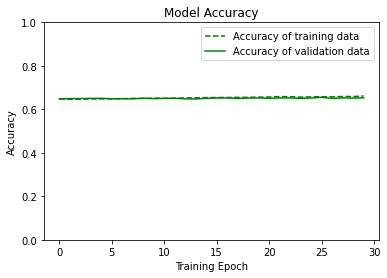

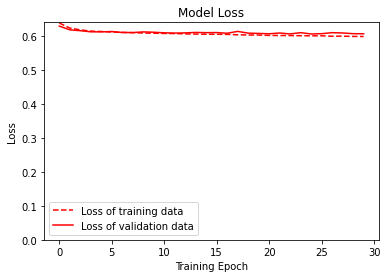

In [23]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
axes = plt.gca()
axes.set_ylim([0,1])
plt.ylim(0)
plt.legend()
plt.show()

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [24]:
def make_classifier(optimizer):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    #model.add(Dense(1))
    model.compile(optimizer= optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [25]:
#accuracies = cross_val_score(estimator = classifier,
#                             X = X_train,
#                             y = y_train,
#                             cv = 10,
#                             n_jobs = -1)

#accuracies

In [26]:
#To obtain the relative accuracies we get the mean of the accuracies.

#mean = accuracies.mean()

#Then the variance.

#variance = accuracies.var()

#Goal: to have a small variance between the accuracies.

#mean, variance

In [28]:
#We’ll still use the KerasClassifier, 
#but we won’t pass the batch size and number of epochs 
#since these are the parameters we want to tune.

classifier = KerasClassifier(build_fn = make_classifier)

#Create a dictionary with the parameters we’d like to tune 

params = {
    'batch_size':[20,32,35],
    'nb_epoch':[30, 50,100,150],
    'optimizer':['adam','rmsprop']
}

#We then use Grid Search to test these parameters.
#It expects our estimator, the parameters we just defined, the scoring metric and the number of k-folds.

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=10)

In [ ]:
#we need to fit our training set.

grid_search = grid_search.fit(X_train,y_train)

#we get the best selection of parameters using best_params from the grid search object

best_param = grid_search.best_params_

#we get the best accuracy score using best_score_

best_accuracy = grid_search.best_score_

#NB: this process will take a while

best_param, best_accuracy

3306/3306 [==============================] - 6s 2ms/step - loss: 0.6337 - accuracy: 0.6484
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
3306/3306 [==============================] - 5s 1ms/step - loss: 0.6382 - accuracy: 0.6462


2067/2067 [==============================] - 3s 2ms/step - loss: 0.6376 - accuracy: 0.6471
